## Imports & Functions

In [1]:
%matplotlib inline

# =-=-=-=-=-=-=-=-=-=-=
# IMPORTS &FXNS
# =-=-=-=-=-=-=-=-=-=-= 

import re, pandas as pd, numpy as np
import sklearn.feature_extraction.text as text
from sklearn.decomposition import NMF
from sklearn.feature_extraction import stop_words
import matplotlib.pyplot as plt

# plt.rcParams['figure.figsize'] = [10, 5]

# =-=-=-=-=-=-=-=-=-=-=
# FUNCTIONS
# =-=-=-=-=-=-=-=-=-=-= 

def string_test(s):
    if s is None:
        return ' '
    else:
        return str(s)

def strainer(the_list):
    strained = []
    for string in the_list:
        string_test(string)
        string = string.replace(u'\xa0', u' ')
        strained.append(string)
    return strained

# Eliminate carriage returns
# legends = []
# for string in strings:
#     string = string.replace(u'\xa0', u' ')
#     legends.append(string)

## Load the Data; Create 3 Groups

In [2]:
# Load the CSV as a dataframe
df = pd.read_csv('./clowns_3.csv')
df.Origin.value_counts()

News Report     162
Social Media     18
Fiction           2
Name: Origin, dtype: int64

In [4]:
df['Date']=pd.to_datetime(df['Date'])

In [5]:
df['Date'] = df['Date'].dt.date

In [6]:
df.head()

Title        Date  \
0  Clown Attack on Woman Forces Cincinnati Suburb...  2016-09-30   
1  Another Clown Was Spotted In The Woods And Pol...  2016-09-06   
2  Everyone in poor moiuntain please stay inside....  2016-09-13   
3                He's the hero this country deserves  2016-10-13   
4  After-dark clown sightings trouble California ...  2014-10-13   

                        Author        Origin  \
0                          NaN   News Report   
1     Michelle Broder Van Dyke   News Report   
2               Melissa Dooley  Social Media   
3                The LAD Bible  Social Media   
4  The Associated Press , WBIR   News Report   

                                                 URL  \
0  http://insider.foxnews.com/2016/09/30/clown-at...   
1  https://www.buzzfeed.com/mbvd/stop-clowning-ar...   
2  https://www.facebook.com/melissa.dooley.397/po...   
3  https://www.facebook.com/LADbible/videos/29391...   
4  http://www.wbir.com/news/after-dark-clown-sigh...   

                                                Text  
0  An Ohio school district closed schools today a...  
1  The latest clown to be spotted was chased back...  
2  I don't know if this is real or fake. I didn't...  
3  Batman, "As for you clowns, if you want to sca...  
4  BAKERSFIELD, California (AP) — People dressed ...

In [7]:
df = df.sort_values(by=['Date'])

In [8]:
# Our core sets of texts
texts = [ string_test(i) for i in df.Text.tolist() ]
news = [ string_test(i) for i in df[df["Origin"] == "News Report"].Text.tolist() ]
social = [ string_test(i) for i in df[df["Origin"] == "Social Media"].Text.tolist() ]

# Metadata for use later
dates = df.Date.tolist()
origins = df.Origin.tolist()

In [13]:
with open('texts-social.txt', 'w') as the_file:
    for item in social:
        the_file.write('%s\n' % item)

In [38]:
print(dates[0:5])

[datetime.date(2014, 7, 31), datetime.date(2014, 10, 11), datetime.date(2014, 10, 13), datetime.date(2016, 7, 22), datetime.date(2016, 8, 4)]


## Topic Model

In [57]:
# STOPWORDS (adding some particularly annoying things to remove to base list)
local_stop = [ 'goldreply', 'points', 'permalinkembedsaveparentreportgive', 
              'permalinkembedsavereportgive' ]
all_stop = text.ENGLISH_STOP_WORDS.union(local_stop)

# Instantiating the vectorizer
vectorizer = text.CountVectorizer(stop_words = all_stop, 
                                  min_df = 2 )
dotomo = vectorizer.fit_transform(texts)
dtm = dotomo.toarray()
vocab = np.array(vectorizer.get_feature_names())
dtm.shape

(182, 4028)

With our 182 texts, we have a vocabulary of 4032 words.

In [49]:
n_topics = 10
n_top_words = 10

clf = NMF(n_components=n_topics, random_state=1)

doctopic = clf.fit_transform(dtm)

topic_words = []
for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:n_top_words]
    topic_words.append([vocab[i] for i in word_idx])

In [50]:
for t in range(len(topic_words)):
    print("Topic {}: {}".format(t, ' '.join(topic_words[t][:15])))

Topic 0: just like didn clown let don time going wasn did
Topic 1: clown police reports clowns children sightings reported local carolina south
Topic 2: ago months clown point just people school comments think like
Topic 3: said greenville clowns clown woods children police apartment told deputies
Topic 4: clown clowns people creepy like says fear hysteria scary just
Topic 5: school police said threats schools reports people county high clowns
Topic 6: clown said 2016 police threats october sightings clowns girl september
Topic 7: said henry clown house police just dude ronald parents time
Topic 8: clowns people clown state penn reports campus said twitter students
Topic 9: clown said event threats march matter lives creepy tucson canceled


In [19]:
doctopic = doctopic / np.sum(doctopic, axis=1, keepdims=True)

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


### Top 3 Topics for Each Text

In [51]:
# Now to associate NMF topics to documents...
print("Top NMF topics in...")
for i in range(len(doctopic)):
    top_topics = np.argsort(doctopic[i,:])[::-1][0:3]
    top_topics_str = ', '.join(str(t) for t in top_topics)
    print("{}, {}, {}".format(dates[i], origins[i], top_topics_str))

Top NMF topics in...
2014-07-31, News Report, 4, 1, 6
2014-10-11, News Report, 4, 8, 0
2014-10-13, News Report, 5, 8, 1
2016-07-22, News Report, 3, 0, 2
2016-08-04, News Report, 6, 1, 7
2016-08-26, Social Media, 6, 3, 9
2016-08-26, News Report, 3, 6, 9
2016-08-29, News Report, 1, 3, 6
2016-08-29, News Report, 3, 7, 4
2016-08-29, News Report, 3, 4, 8
2016-08-29, News Report, 3, 5, 2
2016-08-29, News Report, 3, 4, 1
2016-08-30, News Report, 3, 4, 1
2016-08-30, News Report, 3, 4, 9
2016-08-30, News Report, 3, 4, 1
2016-08-31, News Report, 3, 7, 1
2016-08-31, News Report, 5, 1, 6
2016-08-31, News Report, 3, 7, 8
2016-09-01, News Report, 3, 5, 7
2016-09-01, News Report, 3, 6, 1
2016-09-01, News Report, 3, 6, 9
2016-09-02, News Report, 3, 5, 7
2016-09-02, News Report, 3, 1, 5
2016-09-03, News Report, 3, 1, 4
2016-09-05, News Report, 3, 6, 7
2016-09-05, News Report, 3, 1, 5
2016-09-05, Social Media, 6, 0, 2
2016-09-05, News Report, 3, 1, 6
2016-09-05, News Report, 1, 3, 5
2016-09-06, News Rep

## Graphing the Topic Model

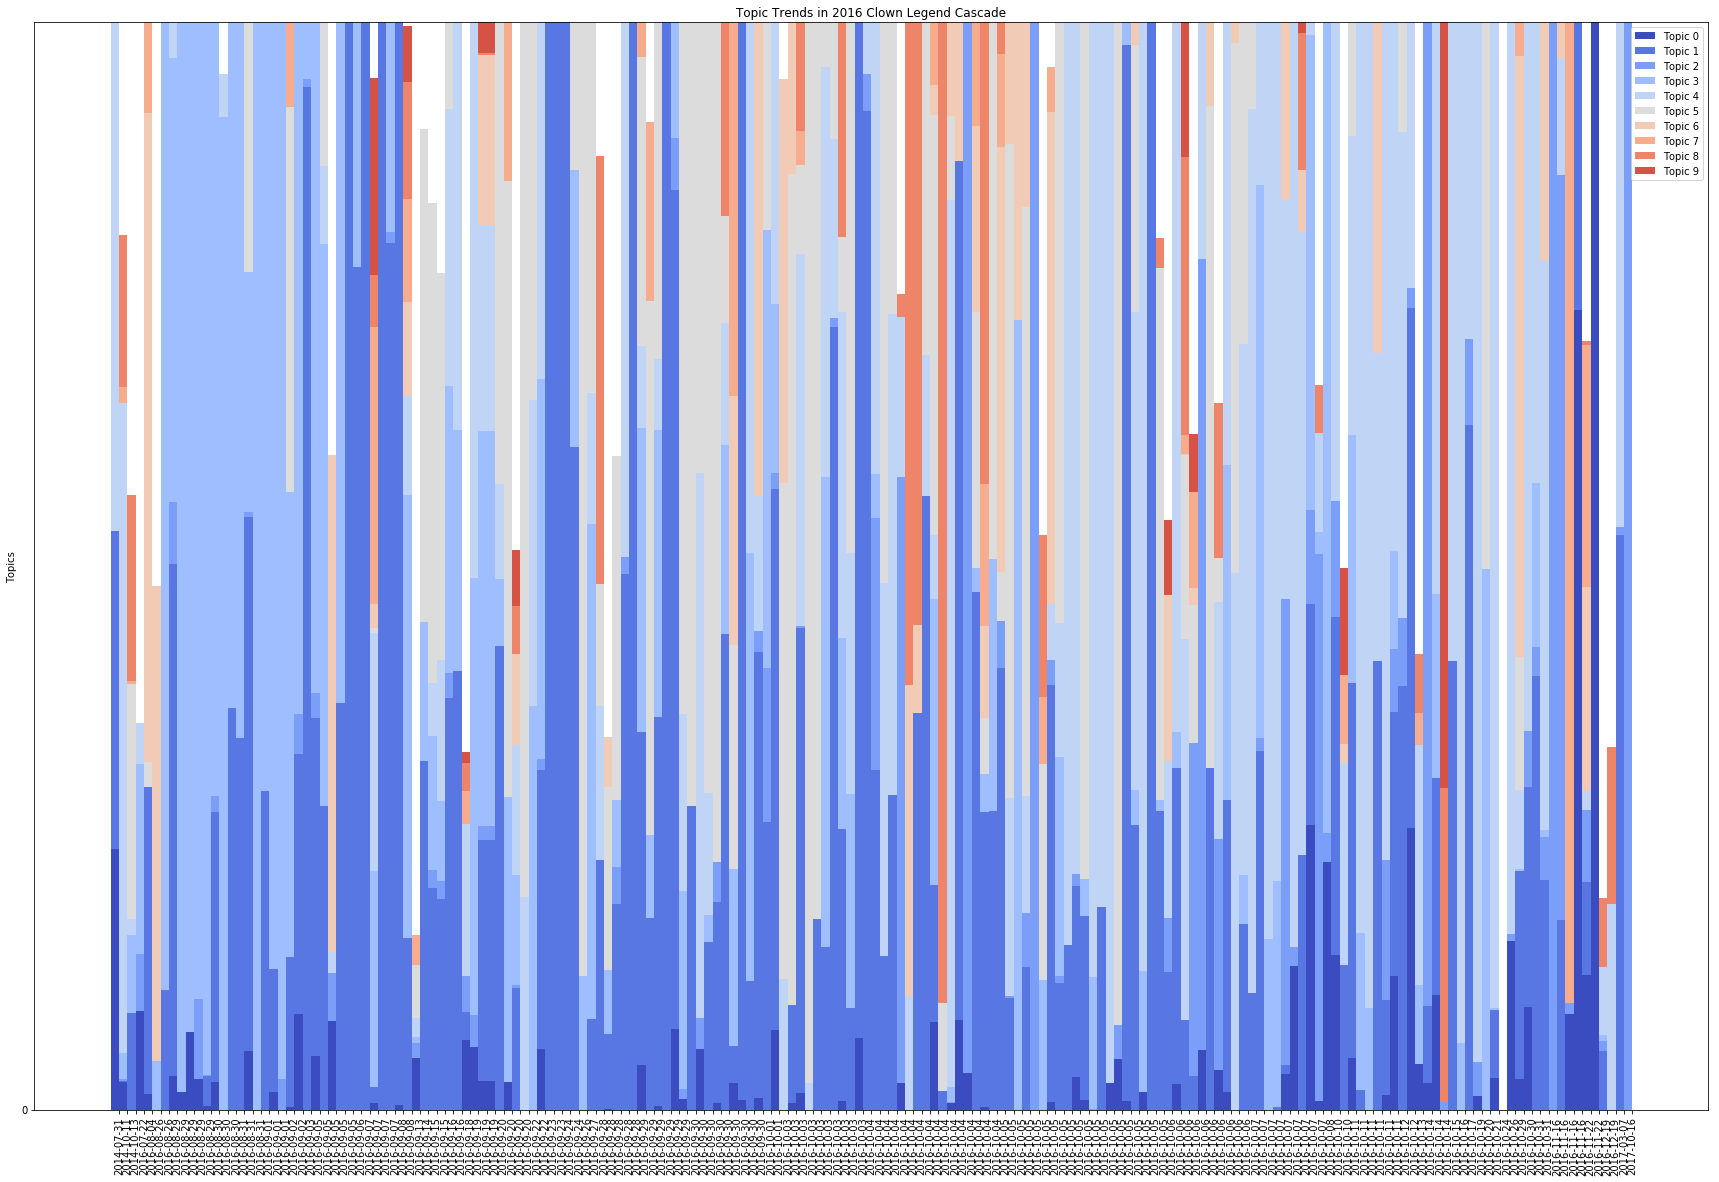

In [52]:
plt.rcParams["figure.figsize"]=30,20

N, K = doctopic.shape  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the texts
width = 1  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, doctopic[:, k], width, color=color)
    else:
        p = plt.bar(ind, doctopic[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += doctopic[:, k]
    plots.append(p)

topic_labels = ['Topic {}'.format(k) for k in range(K)]

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')
plt.title('Topic Trends in 2016 Clown Legend Cascade')
plt.xticks(ind+width/2, dates, rotation='vertical')
plt.yticks(np.arange(0, 1, 10))
plt.legend([p[0] for p in plots], topic_labels, loc="upper right")
plt.show()
# plt.savefig("image.png")

## More Graphs

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

## Alternate Route to Topic Dominance for Genres

In [77]:
topics = pd.read_csv('./topics-trends-20.csv')
topics.head(6)

Date         Origin  T1  T2  T3
0  2014-07-31    News Report  15  17  14
1  2014-10-11    News Report   4  19  14
2  2014-10-13    News Report   6   5   4
3  2016-07-22    News Report  14  12  10
4  2016-08-04    News Report  17   6   5
5  2016-08-26   Social Media  11   4  10

In [71]:
for col in topics.columns:
    print(col)

Date
Origin
T1
T2
T3


In [83]:
topics_news = topics[topics["Origin"] == " News Report"]
topics_news.shape

(162, 5)

In [90]:
topics_news.T3.value_counts() # Repeated for each of 3 more prominent topics

6     21
5     19
4     18
14    17
17    14
1     11
10    11
19    10
15    10
16     7
12     7
3      3
18     3
8      3
11     2
2      2
9      1
7      1
13     1
0      1
Name: T3, dtype: int64

In [87]:
topics_social = topics[topics["Origin"] == " Social Media"]
topics_social.shape

(18, 5)

In [92]:
topics_social.T3.value_counts()

17    3
19    2
9     2
5     2
14    1
10    1
7     1
6     1
4     1
3     1
2     1
1     1
0     1
Name: T3, dtype: int64

Once a count for the three most prominent topics in each group, news report and social media, is compiled. We can cross-check for topics most common and most in common as well as those topics that are trend toward one genre or the other.